In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import nltk
import re
# Import word_tokenize and stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

import nltk
import nltk.corpus
from gensim.models.word2vec import Word2Vec
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
# Shape of each set

print("Shape of TRAIN DATA: ", train.shape)
print("Shape of TEST DATA: ", test.shape)

Shape of TRAIN DATA:  (10240, 2)
Shape of TEST DATA:  (2551, 2)


# Sentiment Analysis

Get polarity and subjectivity scores of the news with TextBlob

In [5]:
# Import the TextBlob
from textblob import TextBlob

In [14]:
# Add polarities and subkectivities into the DataFrame by using TextBlob
train["Polarity"] = train["Statement"].apply(lambda word: TextBlob(word).sentiment.polarity)
train["Subjectivity"] = train["Statement"].apply(lambda word: TextBlob(word).sentiment.subjectivity)

test["Polarity"] = train["Statement"].apply(lambda word: TextBlob(word).sentiment.polarity)
test["Subjectivity"] = train["Statement"].apply(lambda word: TextBlob(word).sentiment.subjectivity)


# Display the Polarity and Subjectivity columns
display(train[["Statement","Polarity","Subjectivity"]].head(10))

,Statement,Polarity,Subjectivity
0,Says the Annies List political group supports ...,0.000000,0.100000
1,When did the decline of coal start? It started...,0.100000,0.400000
2,"Hillary Clinton agrees with John McCain ""by vo...",0.000000,0.000000
3,Health care reform legislation is likely to ma...,0.200000,0.900000
4,The economic turnaround started at the end of ...,0.200000,0.200000
5,The Chicago Bears have had more starting quart...,0.100000,0.296667
6,Jim Dunnam has not lived in the district he re...,0.000000,0.000000
7,I'm the only person on this stage who has work...,-0.044444,0.555556
8,"However, it took $19.5 million in Oregon Lotte...",0.136364,0.454545
9,Says GOP primary opponents Glenn Grothman and ...,0.325000,0.500000


In [15]:
# Define a function to classify polarities
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

# Apply the funtion on Polarity column and add the results into a new column
train["SentLabel"] = train["Polarity"].apply(analyse_polarity)

# Display the Polarity and Subjectivity Analysis
display(train[["SentLabel"]].head(10))

,SentLabel
0,Neutral
1,Positive
2,Neutral
3,Positive
4,Positive
5,Positive
6,Neutral
7,Negative
8,Positive
9,Positive


In [8]:
# Print the value counts of the SentLabel column
print(train["SentLabel"].value_counts())

Neutral     4635
Positive    3677
Negative    1928
Name: SentLabel, dtype: int64


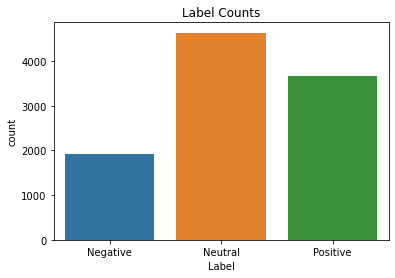

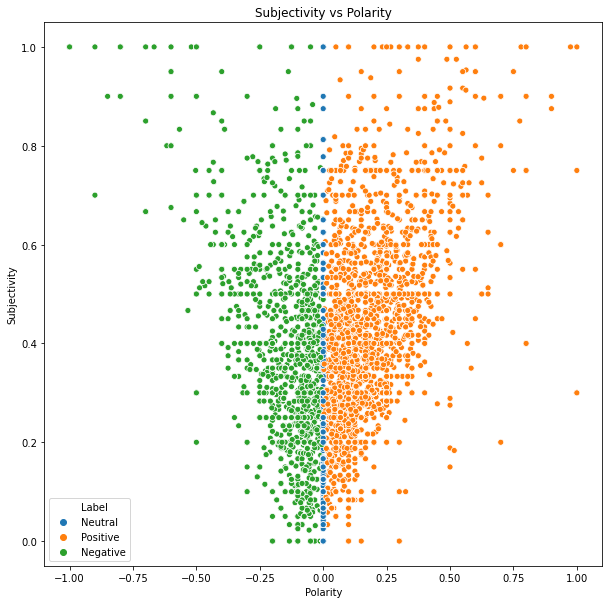

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# Change the datatype as "category"
train["SentLabel"] = train["SentLabel"].astype("category")

# Visualize the Label counts
sns.countplot(train["SentLabel"])
plt.title("Label Counts")
plt.show()

# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="Polarity", y="Subjectivity", hue="Label", data=train)
plt.title("Subjectivity vs Polarity")
plt.show()

In [3]:
def process_statements(text):
    
    # Tokenize the words
    tokenized = word_tokenize(text)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words, changing text to lowercase
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token.lower(), pos='a') for token in tokenized]

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
    
    return tokenized
    
# Call the function and store the result into a new column
#train["Processed"] = train['Statement'].str.lower().apply(process_statements)

# Print the first fifteen rows of Processed
#display(train[["Processed"]].head(15))

In [4]:
train.head()

,Statement,Label
0,Says the Annies List political group supports ...,False
1,When did the decline of coal start? It started...,True
2,"Hillary Clinton agrees with John McCain ""by vo...",True
3,Health care reform legislation is likely to ma...,False
4,The economic turnaround started at the end of ...,True


In [42]:
#from sklearn.model_selection import train_test_split
#Train test split
#X_train, X_test, y_train, y_test = train_test_split(train["Statement"], train["Label"], test_size=0.25)

In [5]:
X_train = train["Statement"]
X_test = test["Statement"]
y_train = train["Label"]
y_test = test["Label"]

In [6]:
print(X_train.shape)

(10240,)


In [7]:
# Vectorize the text so the models can actually interpret it
vectorizer = TfidfVectorizer(analyzer=process_statements)
x_train_vectorized = vectorizer.fit_transform(X_train)
x_test_vectorized = vectorizer.transform(X_test)

In [8]:
print (x_train_vectorized.shape)
print (x_test_vectorized.shape)
print (y_train.shape)
print (y_test.shape)



(10240, 11179)
(2551, 11179)
(10240,)
(2551,)


In [9]:
print(x_train_vectorized)

  (0, 2601)	0.3964316618130959
  (0, 30)	0.33666064253400446
  (0, 9759)	0.3116854938641983
  (0, 4372)	0.3403465781726439
  (0, 7488)	0.3332179180997368
  (0, 5821)	0.3752681135465199
  (0, 445)	0.49799986716152295
  (0, 8760)	0.12904922797568633
  (1, 165)	0.2010759910003482
  (1, 1329)	0.2890425637797335
  (1, 4177)	0.22300484856706312
  (1, 7662)	0.15180446403077794
  (1, 912)	0.3035572591877658
  (1, 10170)	0.2023461874541922
  (1, 4128)	0.22527084660832758
  (1, 6563)	0.27850852573528995
  (1, 9485)	0.5033154443901114
  (1, 9484)	0.27023519451614997
  (1, 1816)	0.28039853574983103
  (1, 2510)	0.31133074448966613
  (1, 10935)	0.1998461251291283
  (2, 5215)	0.28462189659728576
  (2, 2996)	0.39650173726889065
  (2, 947)	0.3305269891917723
  (2, 1327)	0.23892954258827953
  :	:
  (10237, 8895)	0.3456251458001171
  (10237, 10009)	0.1489215963688747
  (10237, 8760)	0.08521751304697446
  (10238, 5781)	0.44461569455541516
  (10238, 2347)	0.424240581611776
  (10238, 3233)	0.433402460741326